In [1]:
import sys
sys.path.append("/users/spate116/singhlab/GCN_Integration/scripts/BI/pyro_model/model")

import os.path as osp

import pyro
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, GNNExplainer
import seaborn as sns

from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')

from model.BayesExplainer import BayesExplainer
from model.samplers.BetaBernoulliSampler import BetaBernoulliSampler
from model.samplers.NFSampler import NFSampler
from model.samplers.SpikeSlabSampler import SpikeSlabSampler
from model.samplers.RandomWalkSampler import RandomWalkSampler
from model.samplers.ConstrainedRandomWalkSampler import ConstrainedRandomWalkSampler

from tqdm.autonotebook import tqdm

dataset = 'Cora'
path = osp.join('data', 'Planetoid')
dataset = Planetoid(path, dataset, transform=T.NormalizeFeatures())
data = dataset[0]


class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, 32)
        self.conv2 = GCNConv(32, 16)
        self.linear = torch.nn.Linear(16, dataset.num_features)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = self.linear(x)
        return F.log_softmax(x, dim=1)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
x, edge_index = data.x, data.edge_index

pbar = tqdm(range(1000))
for epoch in pbar:
    model.train()
    optimizer.zero_grad()
    log_logits = model(x, edge_index)
    loss = F.nll_loss(log_logits[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    pbar.set_description("Loss -> %.5f" % loss.item())
model.eval()

/users/spate116/ml/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


Net(
  (conv1): GCNConv(1433, 32)
  (conv2): GCNConv(32, 16)
  (linear): Linear(in_features=16, out_features=1433, bias=True)
)

Explain node 10: 100%|██████████| 200/200 [00:00<00:00, 356.05it/s]


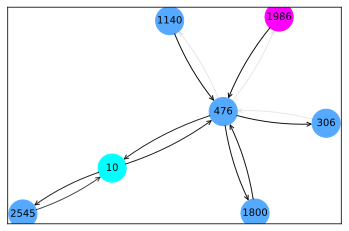

In [2]:
explainer = GNNExplainer(model, epochs=200)
node_idx = 10
node_feat_mask, edge_mask = explainer.explain_node(node_idx, x, edge_index)
ax, G = explainer.visualize_subgraph(node_idx, edge_index, edge_mask, y=data.y)
plt.show()

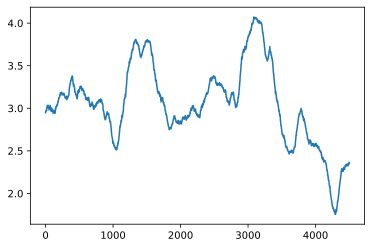

In [3]:
node_idx = 10
k = 2
sampler = BetaBernoulliSampler("cora_beta_bernoulli", 1.0, 3.0)
explainer = BayesExplainer(model, sampler, node_idx, k, x, data.y, edge_index)
avgs = explainer.train(epochs=5000, lr=0.05, window=500)
sns.lineplot(x = range(len(avgs)), y = avgs)

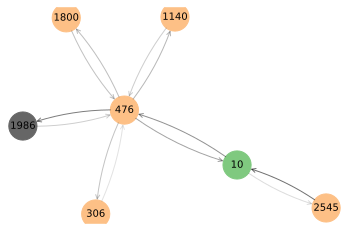

In [4]:
edge_mask = explainer.edge_mask()
ax, G = explainer.visualize_subgraph()
plt.show()

In [5]:
edge_mask

tensor([0.4275, 0.1392, 0.1141, 0.3567, 0.2357, 0.2816, 0.2540, 0.5091, 0.1979,
        0.2452, 0.1937, 0.5579], grad_fn=<DivBackward0>)

In [6]:
node_idx = 10
k = 2
splines = 8
sampler = NFSampler("cora_nf_sampler", splines, True, 5, 1, device)
explainer = BayesExplainer(model, sampler, node_idx, k, x, data.y, edge_index)
avgs = explainer.train(epochs=2500, lr=0.05, window=500)
sns.lineplot(x = range(len(avgs)), y = avgs)

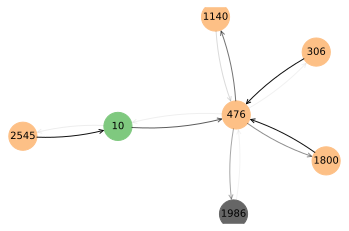

In [ ]:
edge_mask = explainer.edge_mask()
ax, G = explainer.visualize_subgraph()
plt.show()

In [ ]:
edge_mask

tensor([0.6382, 0.0724, 0.9485, 0.0639, 0.0574, 0.5501, 0.4421, 0.3404, 0.1453,
        0.9414, 0.0507, 0.9371], grad_fn=<MeanBackward1>)

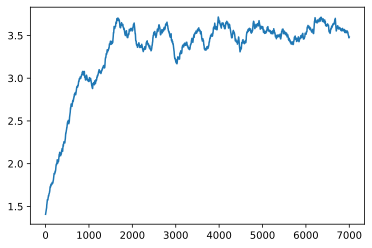

In [ ]:
node_idx = 10
k = 2
sampler = SpikeSlabSampler("cora_spike_slab", 0.25, 1, 5, 10, 1)
explainer = BayesExplainer(model, sampler, node_idx, k, x, data.y, edge_index)
avgs = explainer.train(epochs=7500, lr=0.05, window=500)
sns.lineplot(x = range(len(avgs)), y = avgs)

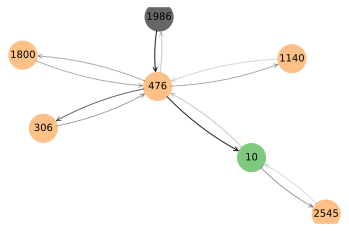

In [ ]:
edge_mask = explainer.edge_mask()
ax, G = explainer.visualize_subgraph()
plt.show()

In [ ]:
edge_mask

tensor([0.2196, 0.3908, 0.3652, 0.8755, 0.6032, 0.3384, 0.3251, 0.2219, 0.1640,
        0.3134, 0.8827, 0.1487], grad_fn=<AddBackward0>)

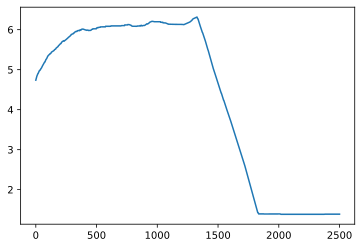

In [ ]:
node_idx = 10
k = 2
sampler = RandomWalkSampler("random_walk", 0.5)
explainer = BayesExplainer(model, sampler, node_idx, k, x, data.y, edge_index)
avgs = explainer.train(epochs=3000, lr=0.5, window=500)
sns.lineplot(x = range(len(avgs)), y = avgs)

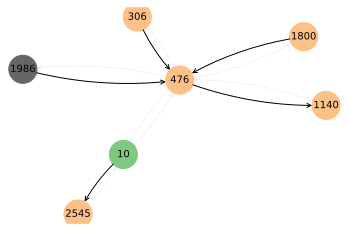

In [ ]:
edge_mask = explainer.edge_mask()
ax, G = explainer.visualize_subgraph()
plt.show()

In [ ]:
edge_mask

tensor([4.1705e-04, 1.6275e-05, 9.9984e-01, 1.5290e-05, 1.4056e-03, 9.3727e-03,
        9.9810e-01, 1.8929e-04, 5.4469e-05, 4.8685e-03, 1.0000e+00, 1.0000e+00],
       grad_fn=<CopySlices>)